In [8]:
import os
import shutil
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split

# 1. Загрузка
raw_path = kagglehub.dataset_download("khushikhushikhushi/dog-breed-image-dataset")
print("Path to dataset files:", raw_path)

# 2. Создание структуры папок для ImageFolder
base_dir = 'dataset_processed'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Очистка старых данных если есть
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

# Список пород из описания (папки в dataset/dataset/)
# В данном датасете структура: {raw_path}/dataset/{breed}
source_dataset_root = os.path.join(raw_path, 'dataset')
breeds = os.listdir(source_dataset_root)

for breed in breeds:
    breed_path = os.path.join(source_dataset_root, breed)
    if not os.path.isdir(breed_path): continue

    images = [f for f in os.listdir(breed_path) if f.endswith('.jpg')]
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Создание папок
    os.makedirs(os.path.join(train_dir, breed), exist_ok=True)
    os.makedirs(os.path.join(val_dir, breed), exist_ok=True)

    # Копирование
    for img in train_imgs:
        shutil.copy(os.path.join(breed_path, img), os.path.join(train_dir, breed, img))
    for img in val_imgs:
        shutil.copy(os.path.join(breed_path, img), os.path.join(val_dir, breed, img))

print(f"Реструктуризация завершена. Данные в: {base_dir}")

Using Colab cache for faster access to the 'dog-breed-image-dataset' dataset.
Path to dataset files: /kaggle/input/dog-breed-image-dataset
Реструктуризация завершена. Данные в: dataset_processed


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(base_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [10]:
model = models.mobilenet_v2(pretrained=True)

# Заморозка backbone
for param in model.parameters():
    param.requires_grad = False

# Кастомный классификатор (Head)
model.classifier = nn.Sequential(
    nn.Linear(model.last_channel, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, len(class_names))
)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 108MB/s]


In [11]:
def train_model(model, criterion, optimizer, epochs=5):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'Epoch {epoch}: {phase} Acc: {epoch_acc:.4f}')

    return model, history

model, history = train_model(model, criterion, optimizer, epochs=5)

Epoch 0: train Acc: 0.6355
Epoch 0: val Acc: 0.8776
Epoch 1: train Acc: 0.9235
Epoch 1: val Acc: 0.9643
Epoch 2: train Acc: 0.9663
Epoch 2: val Acc: 0.9745
Epoch 3: train Acc: 0.9780
Epoch 3: val Acc: 0.9847
Epoch 4: train Acc: 0.9909
Epoch 4: val Acc: 0.9847


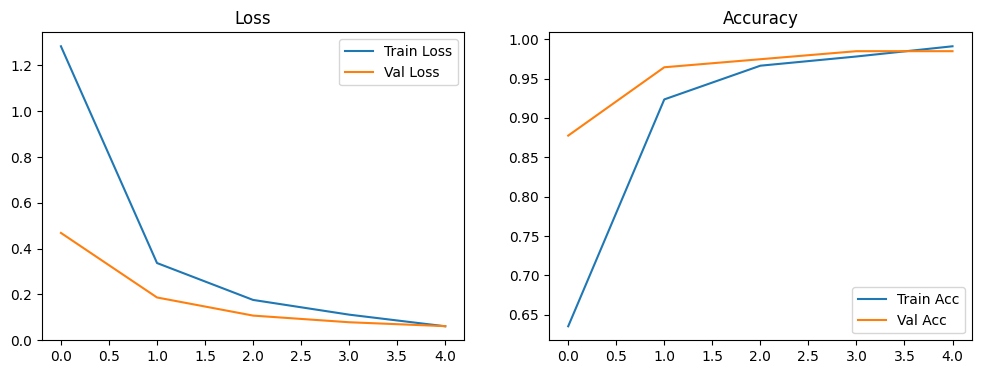

In [12]:
import matplotlib.pyplot as plt

# Построение графиков
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()

# Сохранение весов
torch.save(model.state_dict(), 'tuned_model.pth')